In [1]:
import rasterio
from rasterio import plot
from skimage.util import img_as_float
import skimage.io as skio
from skimage.transform import rescale
from pathlib import Path
import numpy
import matplotlib.pyplot as plt
import zipfile
import xml.etree.ElementTree as ET
from tqdm import tqdm
from collections import OrderedDict
import pickle

import os

repo_path = str(Path().resolve().parent)
os.chdir(repo_path)

In [2]:
os.getcwd()

'C:\\Users\\ETE008168\\OneDrive - INRS\\Documents\\turbidity_repo\\turbidity-analysis'

In [3]:
def get_data_from_zip_file(zip_path):
    zip_format_path = f"zip+file:{zip_path}!"
    meta_data_path = str(Path(zip_path.split("\\")[-1].replace("zip", "SAFE"), "MTD_MSIL2A.xml")).replace("\\", "/")
    with zipfile.ZipFile(zip_path, "r") as f:
        meta_data = ET.fromstring(str(f.read(meta_data_path), "UTF-8"))
        all_file_name = f.filelist
    general_info = meta_data.find("{https://psd-14.sentinel2.eo.esa.int/PSD/User_Product_Level-2A.xsd}General_Info")
    product_info = general_info.find("Product_Info")
    date = product_info.find("PRODUCT_START_TIME").text

    quality_ind = meta_data.find("{https://psd-14.sentinel2.eo.esa.int/PSD/User_Product_Level-2A.xsd}Quality_Indicators_Info")
    cloud_coverage = float(quality_ind.find("Cloud_Coverage_Assessment").text)

    granule_file = list(filter(lambda file: "GRANULE" in file.filename, all_file_name))
    R10m_file = list(filter(lambda file: "R10m" in file.filename, granule_file))
    blue_band_path = list(filter(lambda file: "B02" in file.filename, R10m_file))[0].filename
    green_band_path = list(filter(lambda file: "B03" in file.filename, R10m_file))[0].filename
    red_band_path = list(filter(lambda file: "B04" in file.filename, R10m_file))[0].filename
    nir_band_path = list(filter(lambda file: "B08" in file.filename, R10m_file))[0].filename

    blue_band = rasterio.open(Path(zip_format_path, blue_band_path), driver="JP2OpenJPEG").read(1)
    green_band = rasterio.open(Path(zip_format_path, green_band_path), driver="JP2OpenJPEG").read(1)
    red_band = rasterio.open(Path(zip_format_path, red_band_path), driver="JP2OpenJPEG").read(1)
    nir_band = rasterio.open(Path(zip_format_path, nir_band_path), driver="JP2OpenJPEG").read(1)
    
    return {
        "date": date,
        "cloud_coverage": cloud_coverage,
        "blue_band": blue_band,
        "green_band": green_band,
        "red_band": red_band,
        "nir_band": nir_band
    }
    


In [4]:
sat_folder_list = list(filter(lambda path: ".zip" in str(path), list(Path("data/sentinel2_data/cocagne").iterdir())))

In [8]:
sat_folder_list = sat_folder_list[-2:-1]

In [9]:
data_dict = {}
for sat_folder in tqdm(sat_folder_list):
    sat_dict = get_data_from_zip_file(str(sat_folder))
    date = sat_dict["date"]
    data_dict[date] = sat_dict 
# with open("data_dict.pkl", "wb") as f:
#     pickle.dump(data_dict, f)

# with open("data_dict.pkl", "rb") as f:
#     data_dict = pickle.load(f)


100%|██████████| 1/1 [00:10<00:00, 10.95s/it]


In [10]:
data_dict.keys()

dict_keys(['2022-09-30T15:16:49.024Z'])

In [11]:
od = OrderedDict(sorted(data_dict.items()))

In [12]:
key_to_pop = []
for date, value in od.items():
    if value["cloud_coverage"] > 20:
        key_to_pop.append(date)
for key in key_to_pop:
    od.pop(key)

In [13]:
od.keys()

odict_keys(['2022-09-30T15:16:49.024Z'])

In [17]:
def get_rgb_image_from_data_dict(data_dict, subset=True):
    band2_blue = data_dict["blue_band"]
    band3_green = data_dict["green_band"]
    band4_red = data_dict["red_band"]

    #band2_blue = band2_blue[4500:6500, 5500:7750]
    #band3_green = band3_green[4500:6500, 5500:7750]
    #band4_red = band4_red[4500:6500, 5500:7750]
    #band2_blue = rescale(band2_blue, 0.1, anti_aliasing = True)
    #band3_green = rescale(band3_green, 0.1, anti_aliasing = True)
    #band4_red = rescale(band4_red, 0.1, anti_aliasing = True)

    blue_float = numpy.clip(band2_blue/3000, 0, 1)
    green_float = numpy.clip(band3_green/3000, 0, 1)
    red_float = numpy.clip(band4_red/3000, 0, 1)

    blue_float = band2_blue
    blue_float = band2_blue
    blue_float = band2_blue

    rgb = numpy.dstack((red_float, green_float, blue_float))
    return rgb 

In [18]:
rgb_20 = get_rgb_image_from_data_dict(data_dict["2022-09-30T15:16:49.024Z"])

In [22]:
rgb_20[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.00659451e-06, 6.87534267e-06, 6.20973816e-06],
       [6.15288596e-06, 7.00868578e-06, 6.26799924e-06],
       [6.34944388e-06, 7.14734463e-06, 6.32973724e-06]])

In [20]:
rgb_20.shape

(1098, 1098, 3)

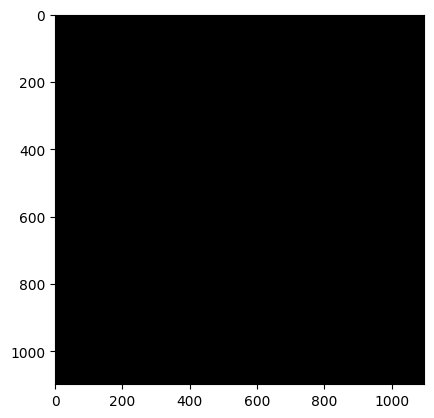

In [21]:
plt.imshow(rgb_20)

In [ ]:
rgb_20 = get_rgb_image_from_data_dict(data_dict["2022-09-30T15:16:49.024Z"])
plt.imshow(rescale(rgb_20, 0.25, anti_aliasing = True, channel_axis=2))
#plt.imshow(rgb_20)

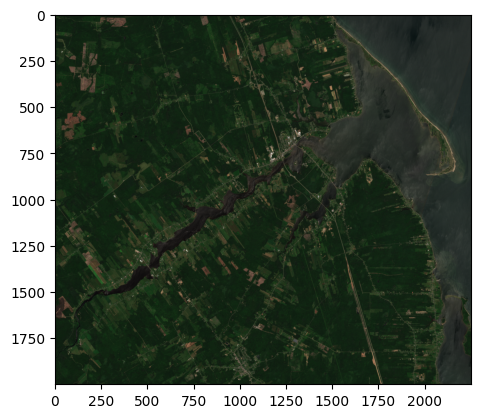

In [23]:
rgb_20 = get_rgb_image_from_data_dict(data_dict["2021-07-25T15:26:31.024Z"])
plt.imshow(rgb_20)
#plt.imshow(rescale(rgb_20, 0.25, anti_aliasing = True, channel_axis=2))

In [24]:
DATE = "2021-07-25T15:26:31.024Z"
data_for_a_date = data_dict[DATE]

In [25]:
band2_blue = data_for_a_date["blue_band"]
band3_green = data_for_a_date["green_band"]
band4_red = data_for_a_date["red_band"]
band8_nir = data_for_a_date["nir_band"]

In [26]:
band2_blue_subset = band2_blue[4500:6500, 5500:7750]
band3_green_subset = band3_green[4500:6500, 5500:7750]
band4_red_subset = band4_red[4500:6500, 5500:7750]
band8_nir_subset = band8_nir[4500:6500, 5500:7750]

In [27]:
blue_float = numpy.clip(band2_blue_subset/4000, 0, 1)
green_float = numpy.clip(band3_green_subset/4000, 0, 1)
redfloat = numpy.clip(band4_red_subset/4000, 0, 1)

In [28]:
rgb = numpy.dstack((redfloat, green_float, blue_float))

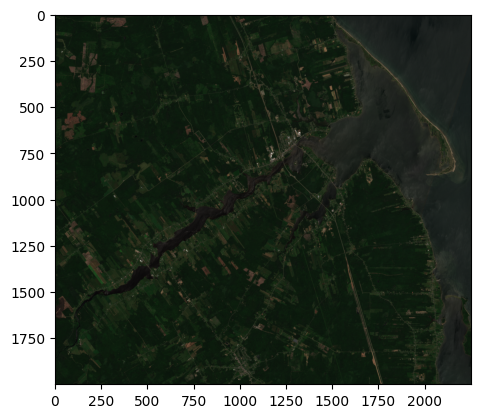

In [29]:
plt.imshow(rgb)

In [30]:
def create_ndwi_raster(green_band, nir_band):
    ndwi = (green_band - nir_band)/(green_band + nir_band)
    return ndwi
def create_ndti_ras(red_band, green_band):
    ndti = (red_band - green_band)/(red_band + green_band)
    return ndti
ndwi = create_ndwi_raster(band3_green_subset, band8_nir_subset)
water_mask = numpy.atleast_3d((ndwi < 0.3)*1)
water = water_mask*rgb
ndti = numpy.atleast_3d(create_ndti_ras(band4_red_subset, band3_green_subset))/255
alpha_array = (numpy.ones_like(water_mask)*0.70*water_mask)[:,:,0]
plt.imshow(rgb)
plt.imshow(ndti*water_mask, cmap="Reds",alpha=alpha_array)
plt.axis("off")
plt.title("Normalized Difference Turbidity Index in Bouctouche Estuary")

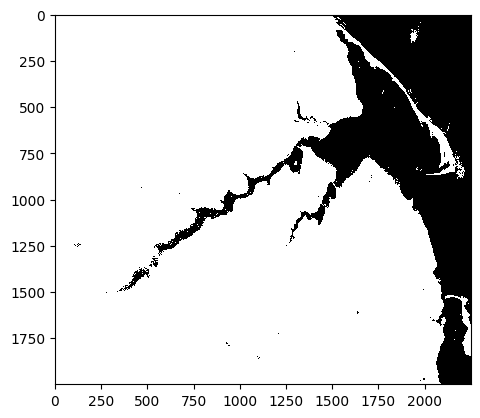

In [33]:
plt.imshow(water_mask, interpolation="nearest", cmap="Greys")

Text(0.5, 1.0, 'Normalized Difference Turbidity Index in Bouctouche Estuary')

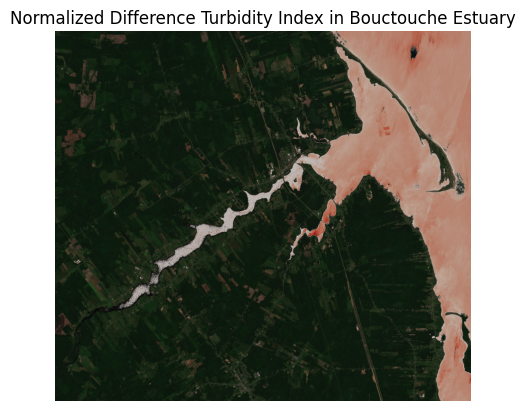